https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sc.settings.verbosity = 2

In [2]:
adata=sc.read_10x_mtx('filtered_gene_bc_matrices/hg19/',cache=True)
adata.var_names_make_unique()

adata

... reading from cache file cache\filtered_gene_bc_matrices-hg19-matrix.h5ad


C:\Users\12990\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [3]:
adata.var_names

Index(['MIR1302-10', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8',
       'AL627309.1', 'RP11-34P13.14', 'RP11-34P13.9', 'AP006222.2',
       'RP4-669L17.10',
       ...
       'KIR3DL2-1', 'AL590523.1', 'CT476828.1', 'PNRC2-1', 'SRSF10-1',
       'AC145205.1', 'BAGE5', 'CU459201.1', 'AC002321.2', 'AC002321.1'],
      dtype='object', length=32738)

In [4]:
adata.obs_names

Index(['AAACATACAACCAC-1', 'AAACATTGAGCTAC-1', 'AAACATTGATCAGC-1',
       'AAACCGTGCTTCCG-1', 'AAACCGTGTATGCG-1', 'AAACGCACTGGTAC-1',
       'AAACGCTGACCAGT-1', 'AAACGCTGGTTCTT-1', 'AAACGCTGTAGCCA-1',
       'AAACGCTGTTTCTG-1',
       ...
       'TTTCAGTGTCACGA-1', 'TTTCAGTGTCTATC-1', 'TTTCAGTGTGCAGT-1',
       'TTTCCAGAGGTGAG-1', 'TTTCGAACACCTGA-1', 'TTTCGAACTCTCAT-1',
       'TTTCTACTGAGGCA-1', 'TTTCTACTTCCTCG-1', 'TTTGCATGAGAGGC-1',
       'TTTGCATGCCTCAC-1'],
      dtype='object', length=2700)

### QC

In [5]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

filtered out 19024 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

In [6]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

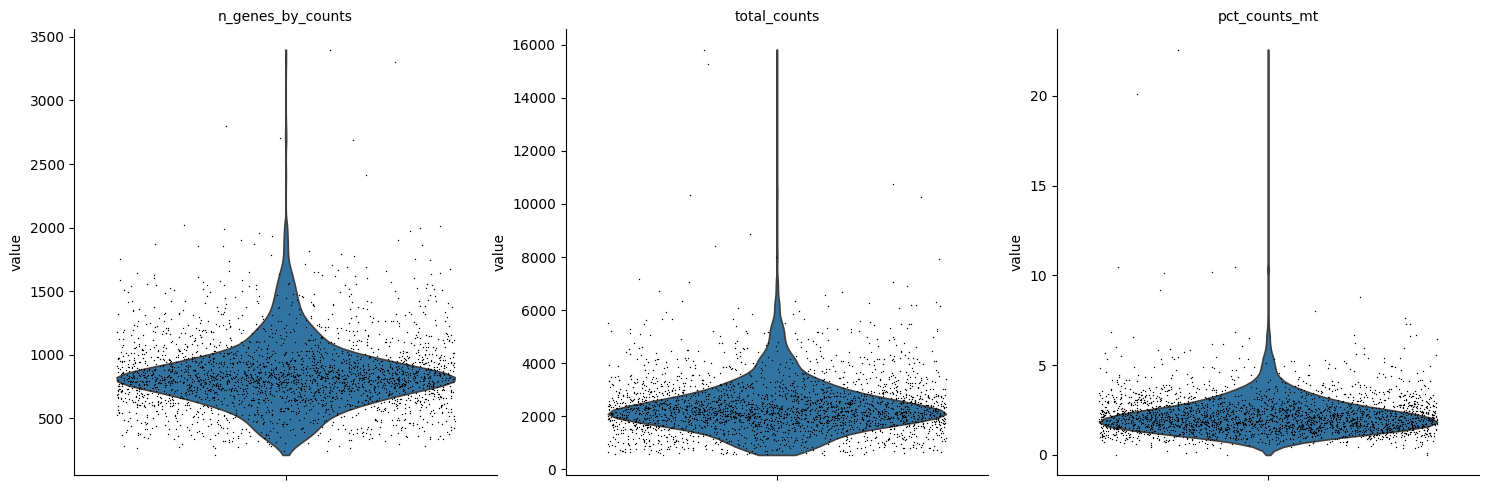

In [7]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

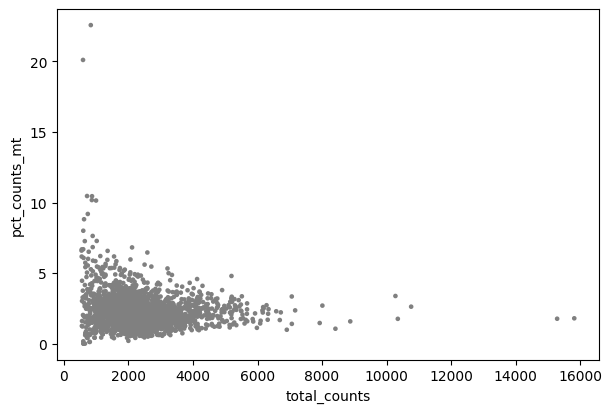

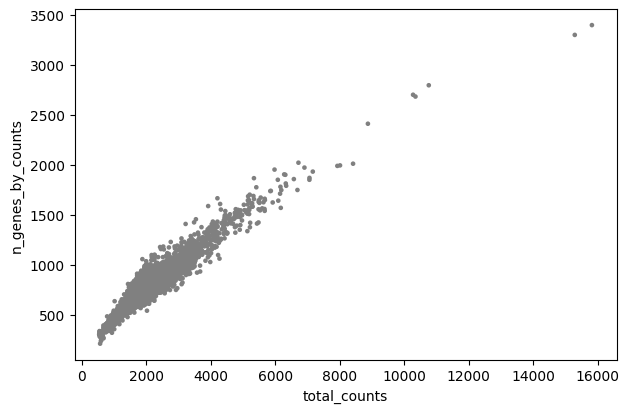

In [8]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [9]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
adata

View of AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Normalize/Scale/HVGs

In [10]:
## Log Normalize
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata) 

## HVGs
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)  ## Genes v.s. Backgrounds, choose via variance
adata = adata[:, adata.var.highly_variable]

## Scale & RegressOut
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])  ## Why RegressOut total_counts?
sc.pp.scale(adata, max_value=10)  ## Max SD:10

adata

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


C:\Users\12990\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


C:\Users\12990\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


    finished (0:00:10)


AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

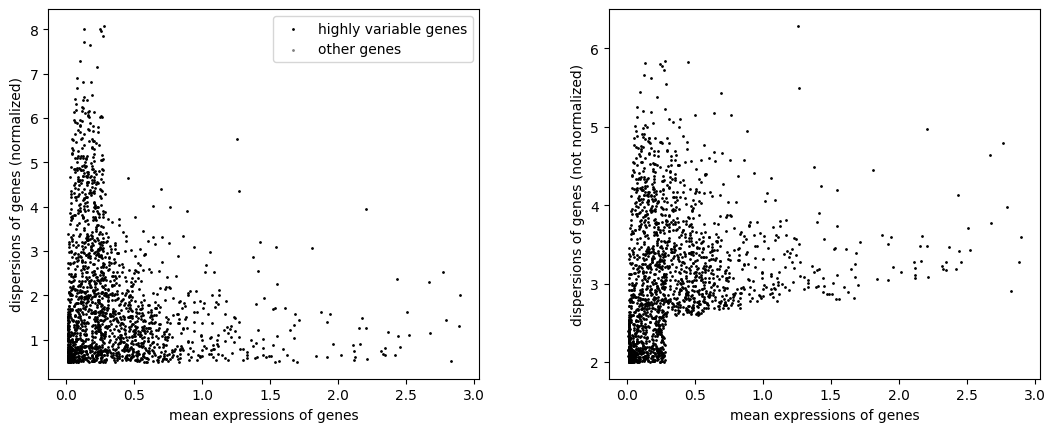

In [11]:
sc.pl.highly_variable_genes(adata)

### PCA/Clustering

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


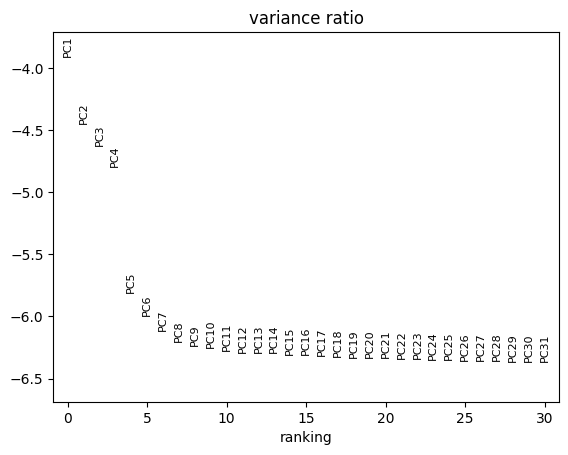

In [12]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata, log=True)

In [13]:
## KNN graph  : adata.uns['neighbors']
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished (0:00:17)


In [14]:
## Clustering 
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    n_iterations=2,
    directed=False,
)

running Leiden clustering
    finished (0:00:00)


In [15]:
adata.obs.leiden

AAACATACAACCAC-1    9
AAACATTGAGCTAC-1    2
AAACATTGATCAGC-1    1
AAACCGTGCTTCCG-1    5
AAACCGTGTATGCG-1    8
                   ..
TTTCGAACTCTCAT-1    0
TTTCTACTGAGGCA-1    2
TTTCTACTTCCTCG-1    2
TTTGCATGAGAGGC-1    2
TTTGCATGCCTCAC-1    1
Name: leiden, Length: 2638, dtype: category
Categories (12, object): ['0', '1', '2', '3', ..., '8', '9', '10', '11']

In [16]:
adata.obs['leiden'] = adata.obs['leiden'].cat.rename_categories({'0':'New0'})
adata.obs['leiden'].cat.categories

Index(['New0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'], dtype='object')

C:\Users\12990\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\12990\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


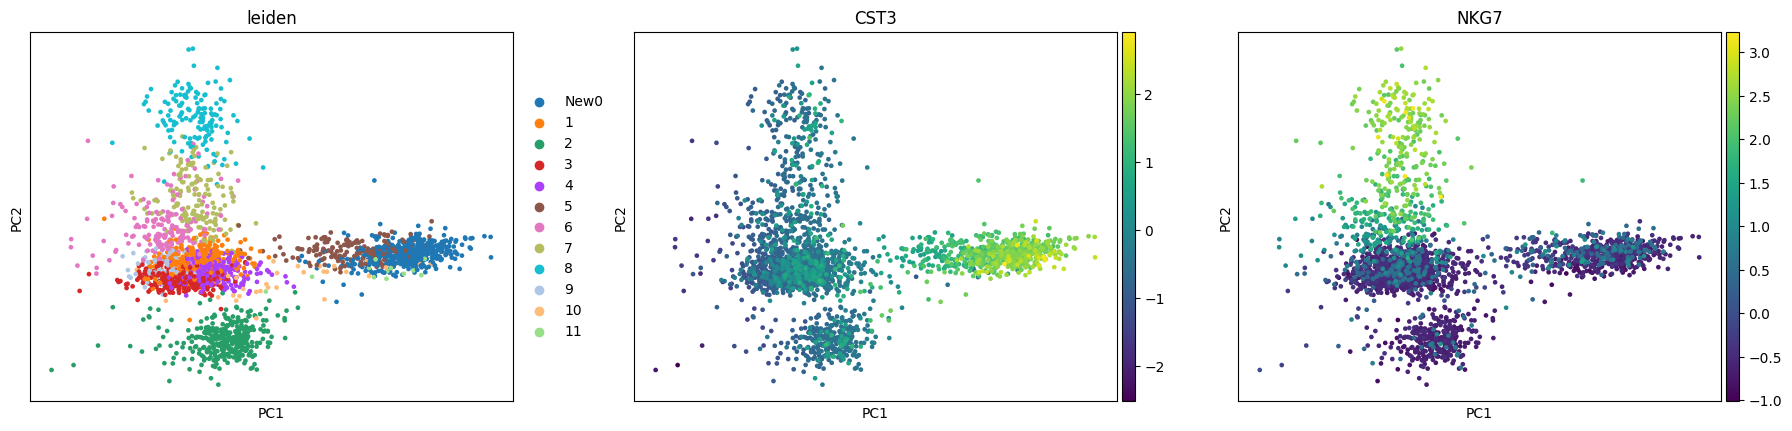

In [17]:
sc.pl.pca(adata, color=["leiden", "CST3", "NKG7"])

### Find Marker

In [18]:
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")

ranking genes
    finished (0:00:00)


C:\Users\12990\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\12990\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\12990\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\12990\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\12990\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: inv

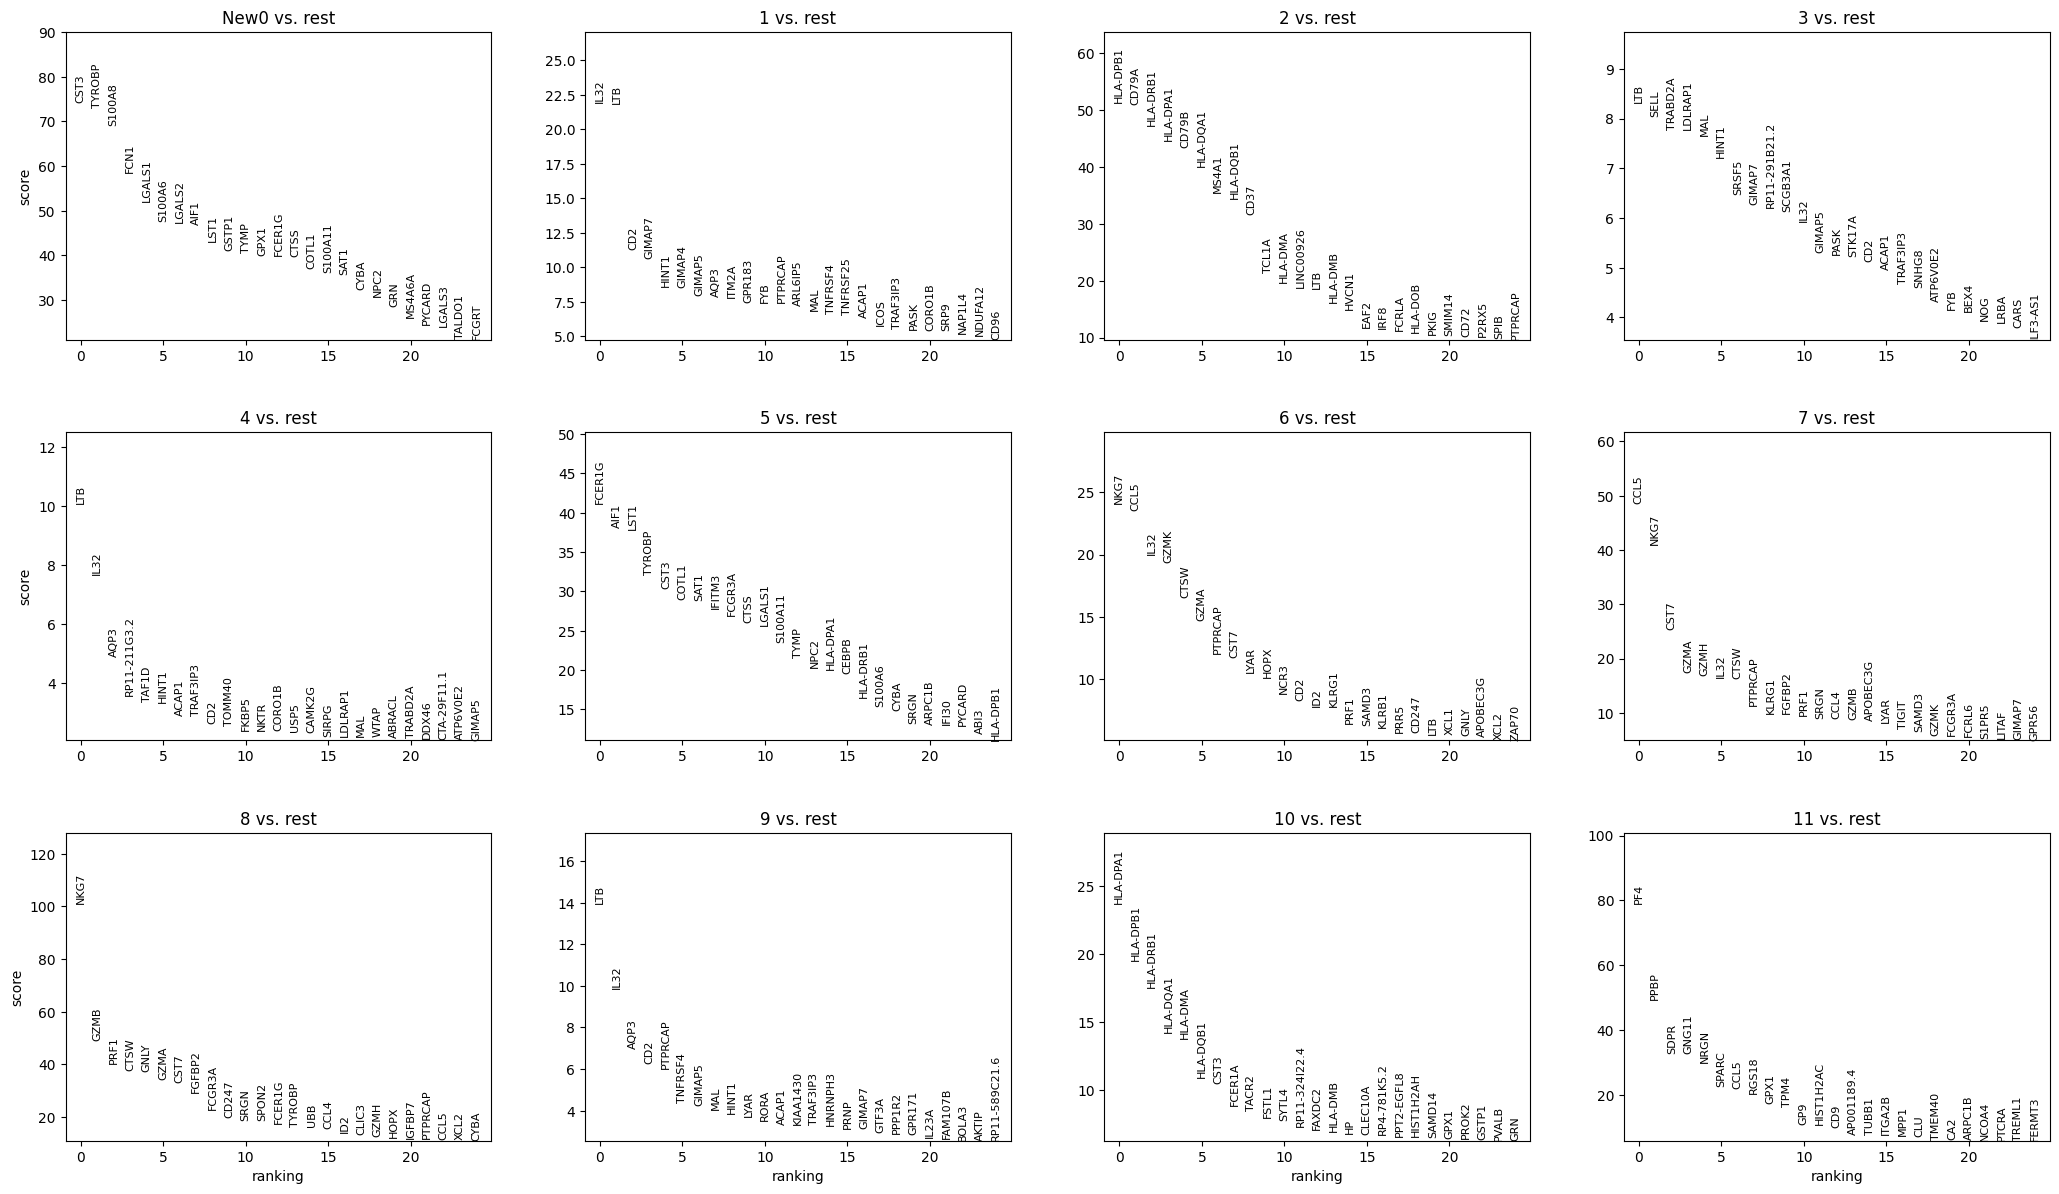

In [19]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [20]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"])

,New0,1,2,3,4,5,6,7,8,9,10,11
0,CST3,IL32,HLA-DPB1,LTB,LTB,FCER1G,NKG7,CCL5,NKG7,LTB,HLA-DPA1,PF4
1,TYROBP,LTB,CD79A,SELL,IL32,AIF1,CCL5,NKG7,GZMB,IL32,HLA-DPB1,PPBP
2,S100A8,CD2,HLA-DRB1,TRABD2A,AQP3,LST1,IL32,CST7,PRF1,AQP3,HLA-DRB1,SDPR
3,FCN1,GIMAP7,HLA-DPA1,LDLRAP1,RP11-211G3.2,TYROBP,GZMK,GZMA,CTSW,CD2,HLA-DQA1,GNG11
4,LGALS1,HINT1,CD79B,MAL,TAF1D,CST3,CTSW,GZMH,GNLY,PTPRCAP,HLA-DMA,NRGN
...,...,...,...,...,...,...,...,...,...,...,...,...
1833,CTSW,HLA-DQA1,GIMAP4,LGALS1,HLA-DPA1,SERPINF1,MS4A6A,LST1,HLA-DQA1,IGSF6,ARL16,C9orf142
1834,CD2,HLA-DRB1,CD2,TYROBP,HLA-DPB1,AQP3,FCN1,LTB,CD79A,TYROBP,DCAF8,CD48
1835,IL32,LGALS2,S100A6,HLA-DPB1,TYROBP,ACAP1,AIF1,CD79A,COTL1,HLA-DPA1,TNFRSF25,RBM3
1836,LTB,FCER1G,GIMAP7,HLA-DPA1,HLA-DQA1,PTPRCAP,LGALS2,LGALS2,LINC00926,LGALS2,CDA,ACAP1


### Pseudo(Trajectory)

running PAGA
    finished (0:00:00)


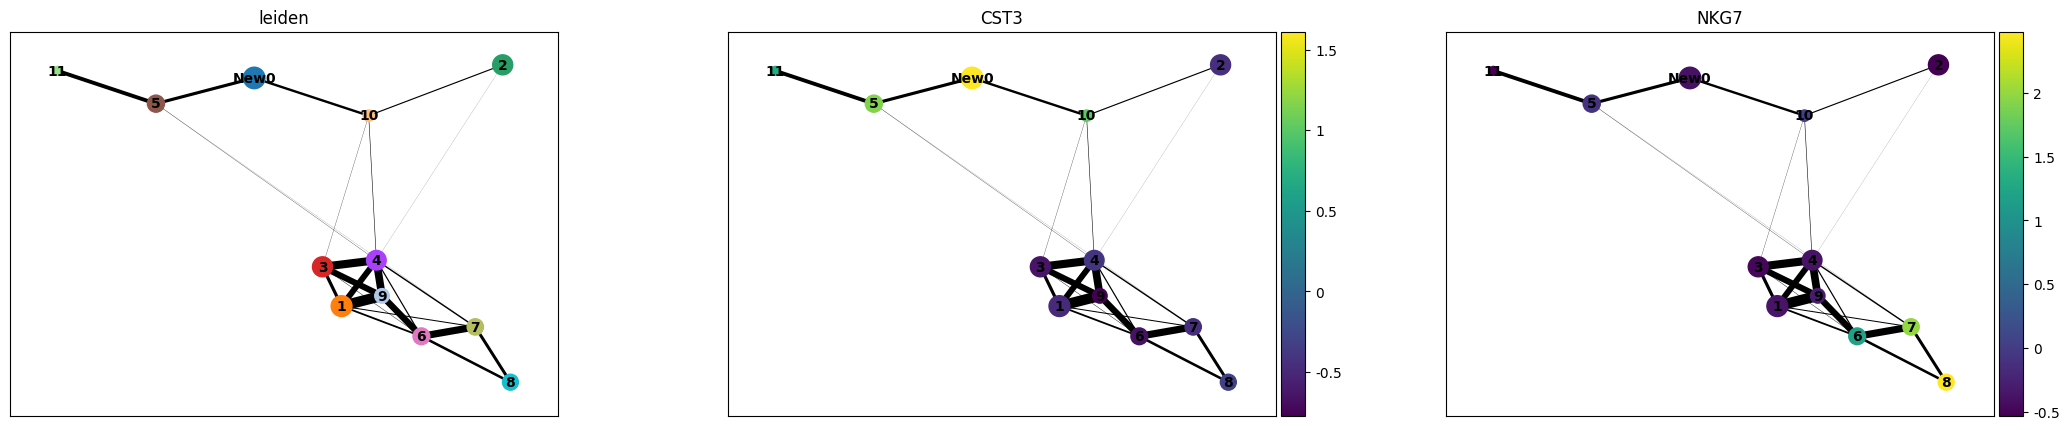

In [21]:
sc.tl.paga(adata, groups='leiden')
sc.pl.paga(adata, color=["leiden", "CST3", "NKG7"])

drawing single-cell graph using layout 'fa'
    finished (0:00:39)


C:\Users\12990\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\12990\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


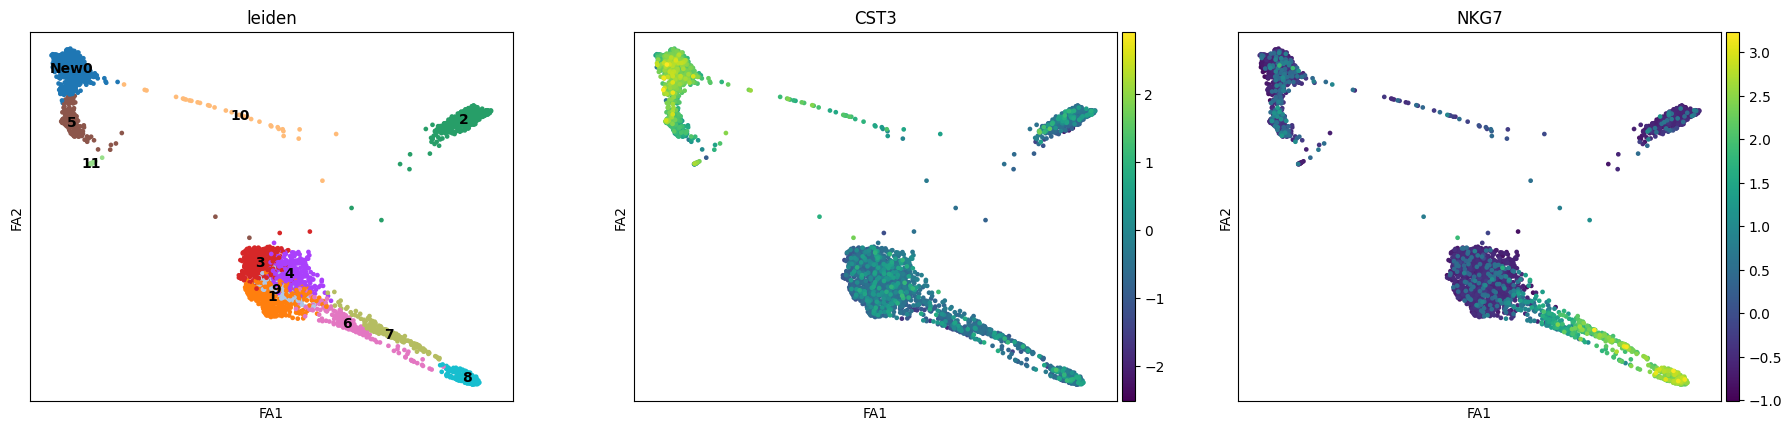

In [22]:
sc.tl.draw_graph(adata, init_pos='paga')
sc.pl.draw_graph(adata, color=["leiden", "CST3", "NKG7"], legend_loc='on data')